# Multi-frequency & Multi-angular selection - CLEAN-T

This script is an example of use of MultiFreqCleanT Class in DeconvolutionMethods library using simulated microphone signals

--Moving source with rotations considered--

In [7]:
import numpy as np
import pylab as pl
import scipy.io as io
from cleantipy.DeconvolutionMethods import MultiFreqCleanT, CleantMap
from cleantipy.Propagation import MovingSrcSimu_t
from Sarradj_2016_array import MicArrayGeom
import time

compute = False

## Parameters 

In [8]:


pref = 2*10**-5 #Pa
fs = 10000
T = 3
Nt = int(fs*T)
t = np.arange(T*fs)/fs 

fs_traj = 4 # 4 GPS points per seceonds
# fs_traj = fs # same as time samplerate
Nt_ = T*fs_traj+1
t_traj = np.arange(Nt_)/fs_traj

# Agngles setup
ang = np.array([(1-np.cos(t_traj/2))/2,0*t_traj,-(1-np.cos(t_traj/2))/3]).T

# Trajectory setup
v = 100   # m/s
Z = 150 # m
Y = 0   # m
X = np.arange(Nt_)*v/fs_traj - T*v/2    # m
traj = np.array([X,Y*np.ones(Nt_),Z*np.ones(Nt_)]).T

# Adding rotations
traj += np.array([0*np.arange(Nt_),-(1-np.cos(t_traj/2))*180/np.pi,0*np.arange(Nt_)]).T

# Micropophone array geometry setup
Nmic = 256
x, y = MicArrayGeom(Nmic,h=2)
z_array = 0

geom = np.array([x,y,z_array*np.ones((Nmic))]).T

# Source definition (position and signal)
sig = np.array([np.random.randn(Nt), # white noise
                np.sin(2*np.pi*440*2*t), # 880 Hz sine
                np.sin(2*np.pi*440*t)]) # 440 Hz sine
pos = np.array([[10,0,0],
                [0,10,0],
                [0,-10,0]]) # relative position to the trajectory

## Run or load the microphone signals

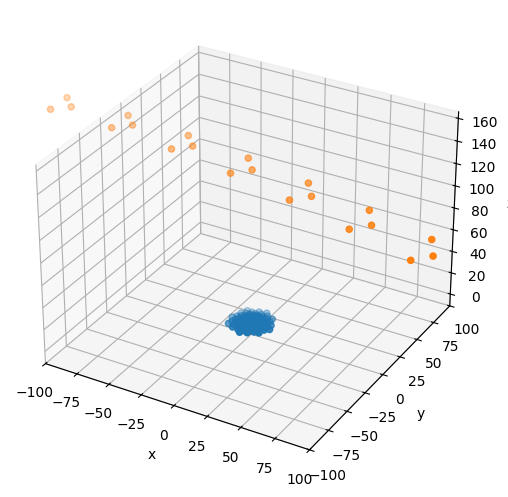

In [9]:

# Define simulation object
simu = MovingSrcSimu_t(geom, pos, traj, t, sig, t_traj=t_traj, angles=ang, SNR=60, timeOrigin='source')


simu.plot()
ax = pl.gca()        
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)


#%% Compute simulated pressures
if compute: 
    try:
        print("** Computing microphone signals **")
        simu.compute(parrallel=True,interpolation="quadratic")
        Sig = simu.p_t
        io.savemat('SimuAngles.mat',{'Sig':Sig})
    except :
        tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
        Sig = tmp['Sig']

else:
    tmp = io.loadmat('SimuAngles.mat',variable_names=['Sig'])
    Sig = tmp['Sig']

del simu

## Define reconstruction grid and angular window selection for CLEAN-T

In [10]:
#%% define image plan relatively to the trajectory
Lx = 40
Ly = 40
resX = 2
resY = 2
x_F = np.arange(0,Lx,resX)-Lx/2
y_F = np.arange(0,Ly,resY)-Ly/2
z_F = 0 
X_F, Y_F, Z_F = np.meshgrid(x_F,y_F,z_F)
grid = np.array([X_F.reshape(-1),Y_F.reshape(-1),Z_F.reshape(-1)]).T



#%% define angle selections
AngleWindows = np.array([[-15, -5],
                         [-5, 5]])


## Set CLEAN-T object

In [11]:
#%% Initialise CLEAN-T
cleant = MultiFreqCleanT(geom,grid,traj,t,Sig,ang,t_traj,debug=False,fc=[400,800],\
                         bandtype='octave',angleSelection=AngleWindows)

## Compute CLEAN-T

In [12]:
print('\n')
print(69*'*')
print("** Starting CLEAN-T computation on a grid following the trajectory **")
print(69*'*')

dyn = 15
t1 = time.time()
cleant.ComputeCleanT(dyn = dyn,parrallel=True)
t2 = time.time()
print("CLEAN-T Computation took %.1f s"%(t2-t1))



*********************************************************************
** Starting CLEAN-T computation on a grid following the trajectory **
*********************************************************************


** Starting CLEAN-T computation over the 400 Hz octave band **
****** Angular window: -15.0--5.0° ******
0 - Residual energy: 100.0%
1 - Residual energy: 44.2%
2 - Residual energy: 6.0%
3 - Residual energy: 2.4%
Residual energy inferior to stop criterion : 5%
****** Angular window: -5.0-5.0° ******
0 - Residual energy: 100.0%
1 - Residual energy: 32.4%
2 - Residual energy: 3.4%
Residual energy inferior to stop criterion : 5%
****** Angular window: -15.0--5.0° ******
Tonal     - 80.6 dB - Pos.: x:0.0	y:-10.0	z:0.0 (rel. traj.) - E: 100.0%
Broadband - 71.4 dB - Pos.: x:10.0	y:0.0	z:0.0 (rel. traj.) - E: 44.2%
Tonal     - 62.8 dB - Pos.: x:0.0	y:-10.0	z:0.0 (rel. traj.) - E: 6.0%
****** Angular window: -5.0-5.0° ******
Tonal     - 80.3 dB - Pos.: x:0.0	y:-10.0	z:0.0 (rel. traj.)

## Display results

C:\Users\leiba\AppData\Local\Temp\ipykernel_32116\1633511416.py:3: MatplotlibDeprecationWarning: Passing the NFFT parameter of specgram() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  pl.specgram(cleant.CleanTObjects[1].Sig[0,:],2048,cleant.CleanTObjects[1].fs,noverlap=1900)
c:\Users\leiba\Documents\CleanTiPy\.venv\Lib\site-packages\matplotlib\axes\_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
C:\Users\leiba\AppData\Local\Temp\ipykernel_32116\1633511416.py:26: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\leiba\AppData\Local\Temp\ipykernel_32116\1633511416.py:26: UserWarning: The figure layout has changed to tight
  pl.tight_layout()


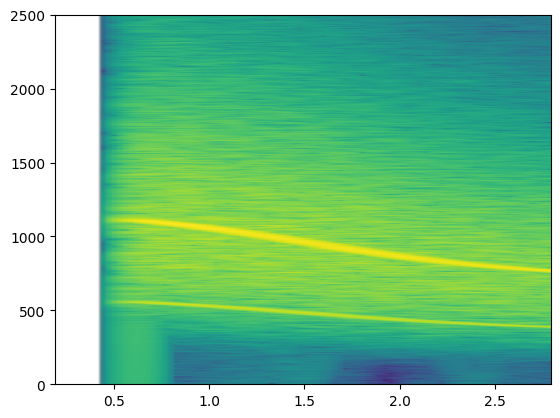

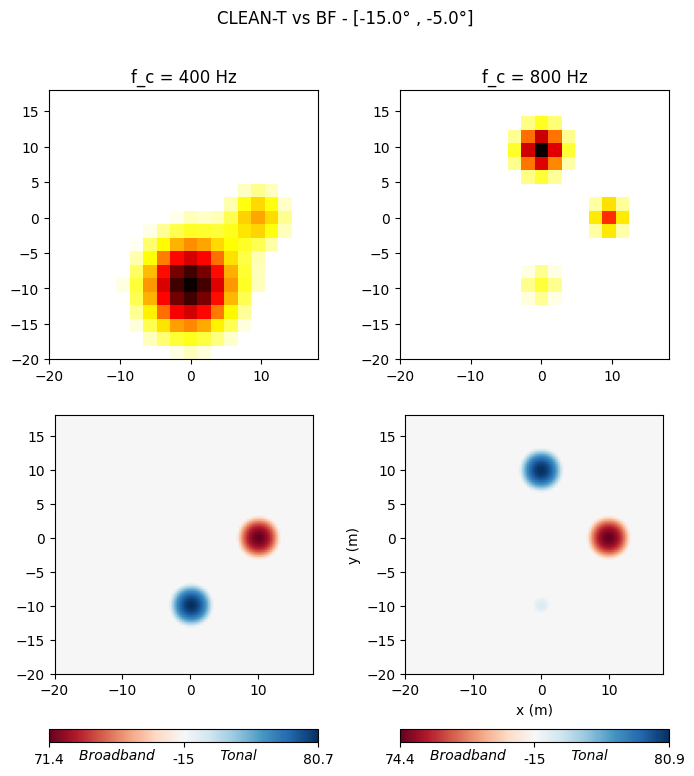

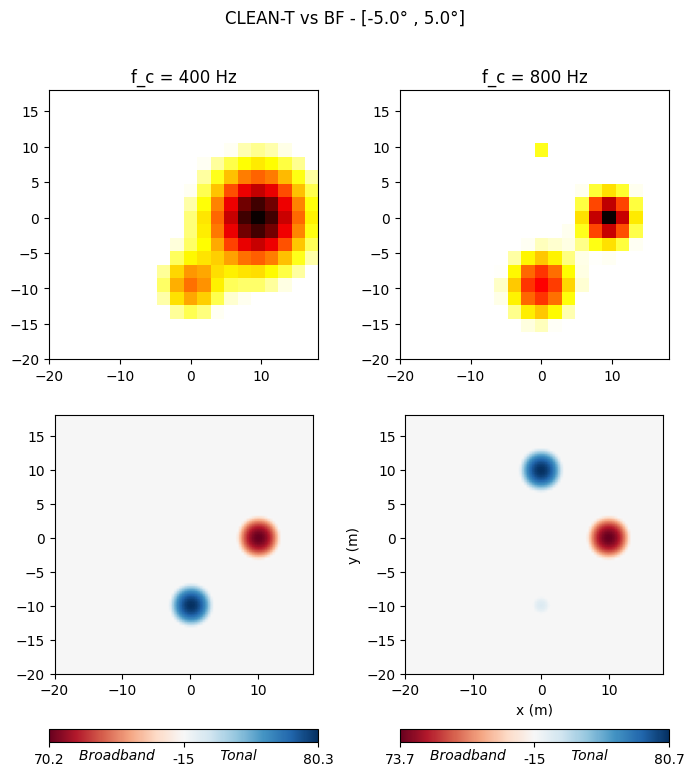

In [13]:
# Check Dopplerization
pl.figure()
pl.specgram(cleant.CleanTObjects[1].Sig[0,:],2048,cleant.CleanTObjects[1].fs,noverlap=1900)



#%% Display results on grid along the trajectory

for ww in range(len(AngleWindows)):

    fig, axs = pl.subplots(2,len(cleant.Results), 
                           constrained_layout=True,figsize=(3.5*len(cleant.Results),8.5))
    fig.suptitle('CLEAN-T vs BF - [%.1f° , %.1f°]' \
                               %(cleant.angleSelection[ww,0],cleant.angleSelection[ww,1]))
    for ff in range(len(cleant.Results)):
        ax = axs[0,ff]
        BF_dB = cleant.Results[ff]['Sources'][0][ww]['AcousticMap'].reshape((y_F.size,x_F.size))        
        mx = np.max(BF_dB)
        ax.imshow(BF_dB, vmax=mx, vmin=mx-dyn, \
                origin='lower',cmap='hot_r',\
                    extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]])
        pl.ylabel('y (m)')
        # fig.colorbar(ax=ax)
        pl.xlabel('x (m)')
        ax.set_title('f_c = %d Hz' %(cleant.Results[ff]['fc']))
        pl.tight_layout()
        
        ax = axs[1,ff]
        CleantMap(cleant.CleanTObjects[ff],gauss=True,dyn=dyn,sameDynRange=False) 
        
        img = ax.imshow(cleant.CleanTObjects[ff].q_disp[ww], origin='lower',
                  extent=[x_F[0],x_F[-1],y_F[0],y_F[-1]], cmap='RdBu',
                  vmin=-dyn,vmax=dyn,interpolation_stage='data')
        cbar = fig.colorbar(img, ax=ax,\
                            ticks=[-dyn, 0, dyn],location="bottom")
        cbar.ax.set_xticklabels(['%.1f' %(cleant.CleanTObjects[ff].qmax_bb[ww]),\
                                 '%d' %(-dyn), '%.1f' %(cleant.CleanTObjects[ff].qmax_ton[ww])])
        # cbar.ax.set_title('[dB]')
        cbar.set_label('Broadband               Tonal       ', fontstyle='italic', labelpad=-13)